In [2]:
#import all necessary libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime
import yfinance as yf

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.models import Sequential, load_model
import tensorflow.keras.backend as k
from tensorflow.keras.losses import MeanAbsoluteError
#from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [3]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-07  166.550003  167.580002  161.429993  162.770004  162.770004   
2024-08-08  165.169998  166.690002  162.550003  165.800003  165.800003   
2024-08-09  166.399994  168.550003  165.850006  166.940002  166.940002   
2024-08-12  168.139999  168.550003  166.110001  166.800003  166.800003   
2024-08-13  167.809998  171.039993  167.100006  170.229996  170.229996   
2024-08-14  172.110001  172.279999  168.860001  170.100006  170.100006   
2024-08-15  174.860001  177.910004  173.990005  177.589996  177.589996   
2024-08-16  177.039993  178.339996  176.259995  177.059998  177.059998   
2024-08-19  177.639999  178.300003  176.160004  178.220001  178.220001   
2024-08-20  178.009995  179.009995  177.430801  178.880005  178.880005   

              Volume company_name  
Date                               
2024-08-07  48408200       AMAZON  
202

In [4]:
# Describe the dataset statistically 
print(company_data['AAPL'].describe())

              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    141.380080   142.977167   139.904525   141.515022   139.772402   
std      41.839174    42.150732    41.547959    41.854837    42.264089   
min      51.025002    51.430000    50.250000    50.660000    49.020836   
25%     120.340000   121.800003   118.834999   120.415001   117.868954   
50%     147.479996   149.119995   145.880005   147.869995   145.696152   
75%     172.445000   174.044998   170.985001   172.834999   171.550720   
max     236.479996   237.229996   233.089996   234.820007   234.548523   

             Volume  
count  1.259000e+03  
mean   9.474025e+07  
std    5.204362e+07  
min    2.404830e+07  
25%    6.038655e+07  
50%    8.100050e+07  
75%    1.119224e+08  
max    4.265100e+08  


In [ ]:
# Describe concisely the features,
# including the number of non-null values and data types
print(company_data['AAPL'].info())

In [ ]:
# Displaying rows and columns for the complete dataset
print("Dimensions of the Data:", df.shape)

In [ ]:
# Displaying rows and columns for Apple
print("Dimensions of the Data:", company_data['AAPL'].shape)

In [ ]:
# Displaying rows and columns for Google
print(company_data['GOOG'].info())

# Describe concisely the features,
# including the number of non-null values and data types for Google 
print("Dimensions of the Data:", company_data['GOOG'].shape)

In [ ]:
# Data Cleaning 
# Handling Missing Values 

# Checking and printing for Missing Values (NaN) in the datasets
print("Are there any missing points in the dataset?:", df.isnull().values.any(), "\n")

In [ ]:
# Handling Duplicate Values:
# Checking and printing for duplicated rows in the DataFrame
print("Number of Duplicated Rows:", df.duplicated().sum(), "\n")

In [ ]:
# No need to remove duplicated and recheck 
# for dimensions because there are no duplicate

In [ ]:
data = company_data['AAPL']
#data = df 
# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

In [ ]:
sns.boxplot(data)

In [ ]:
# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

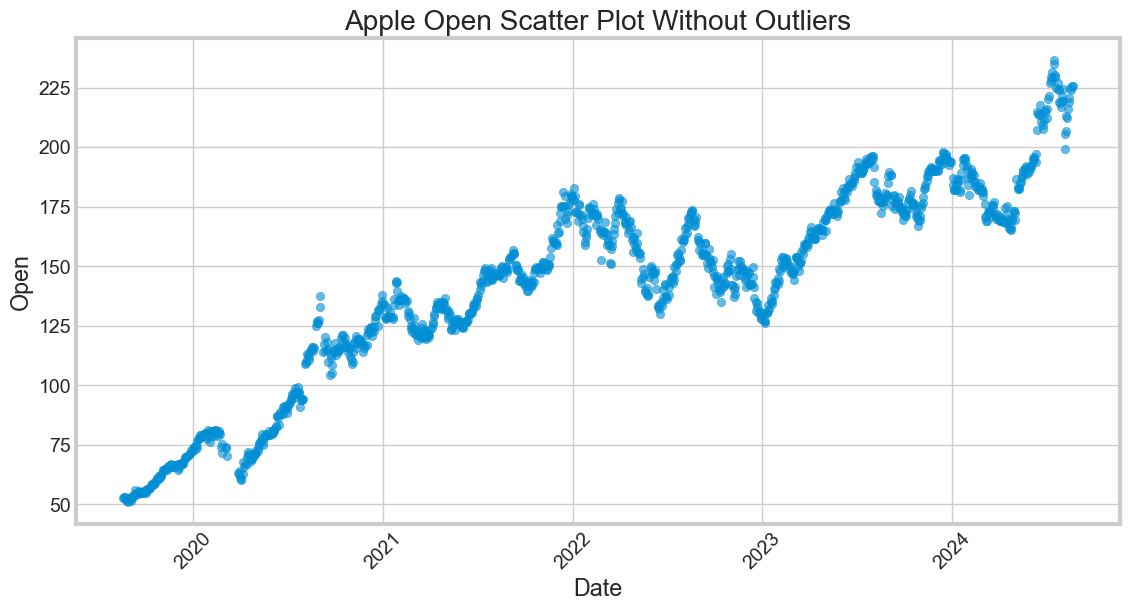

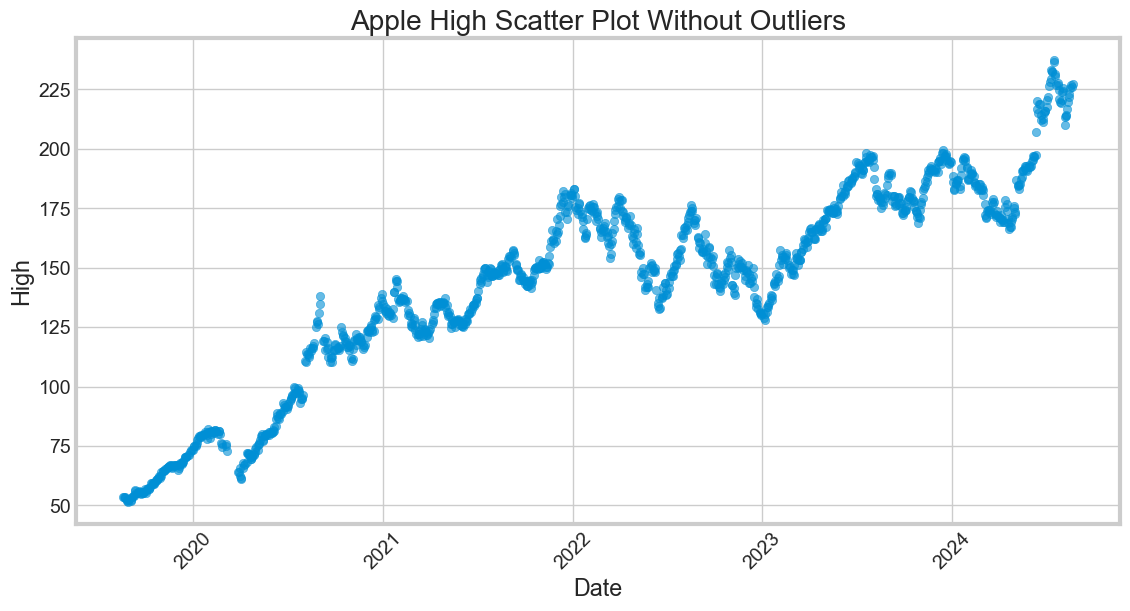

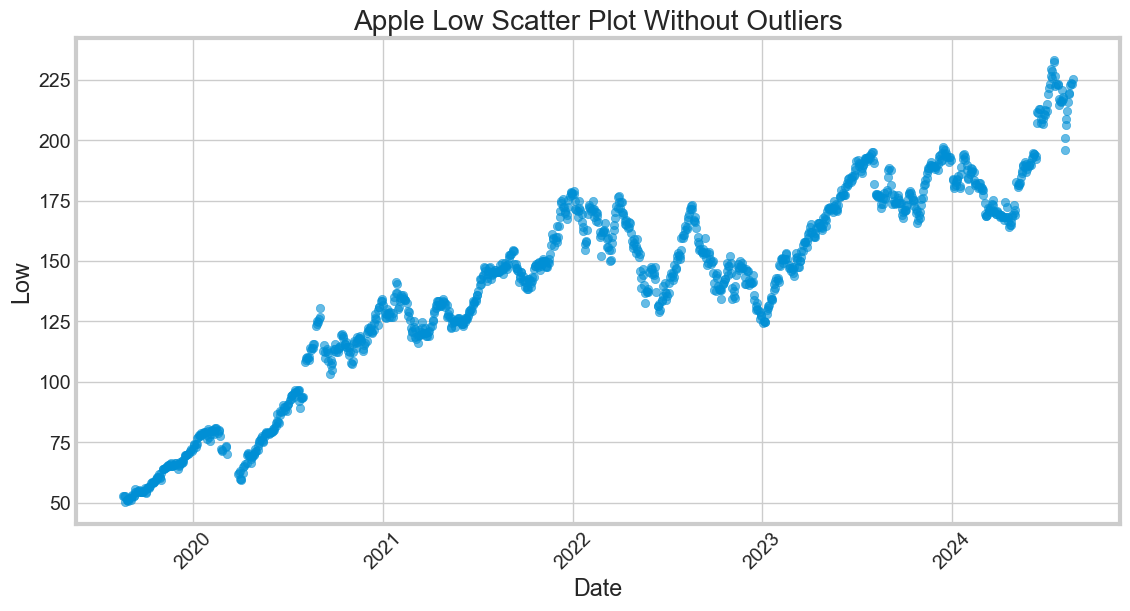

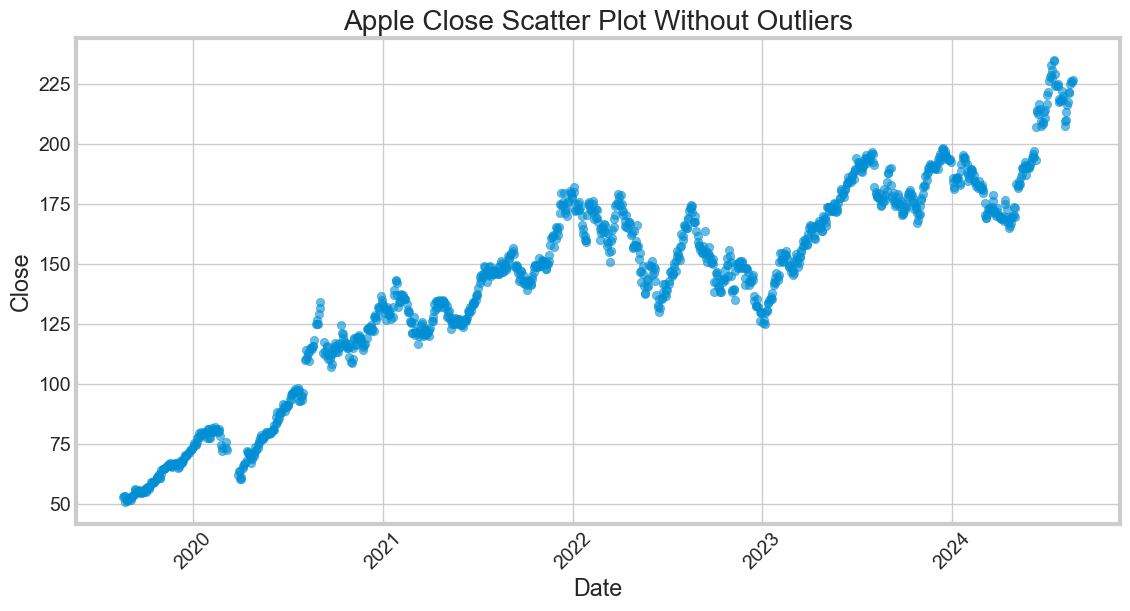

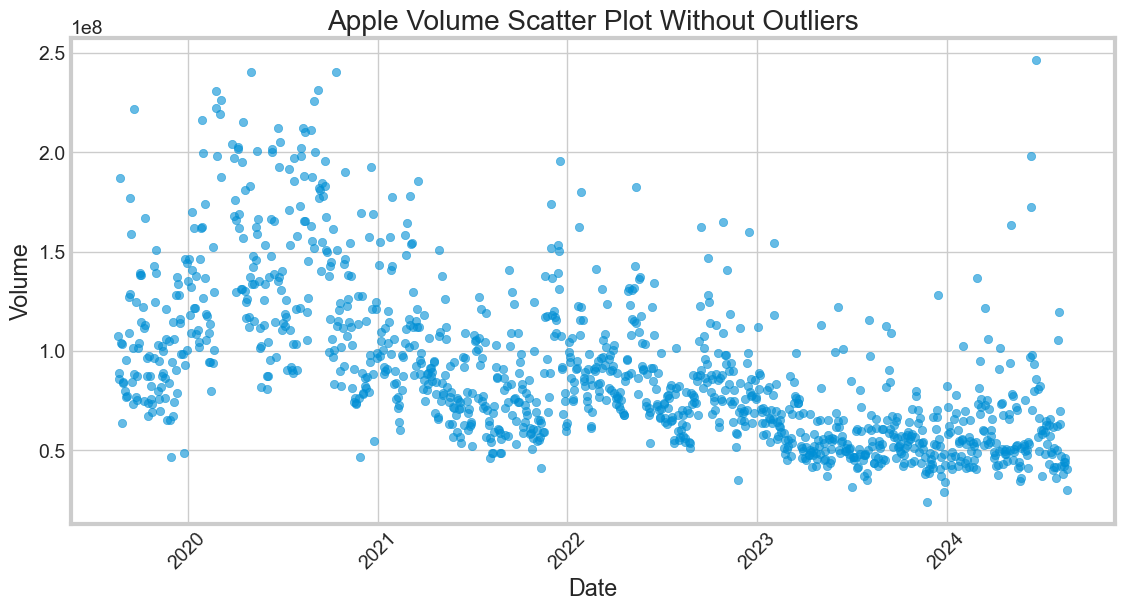

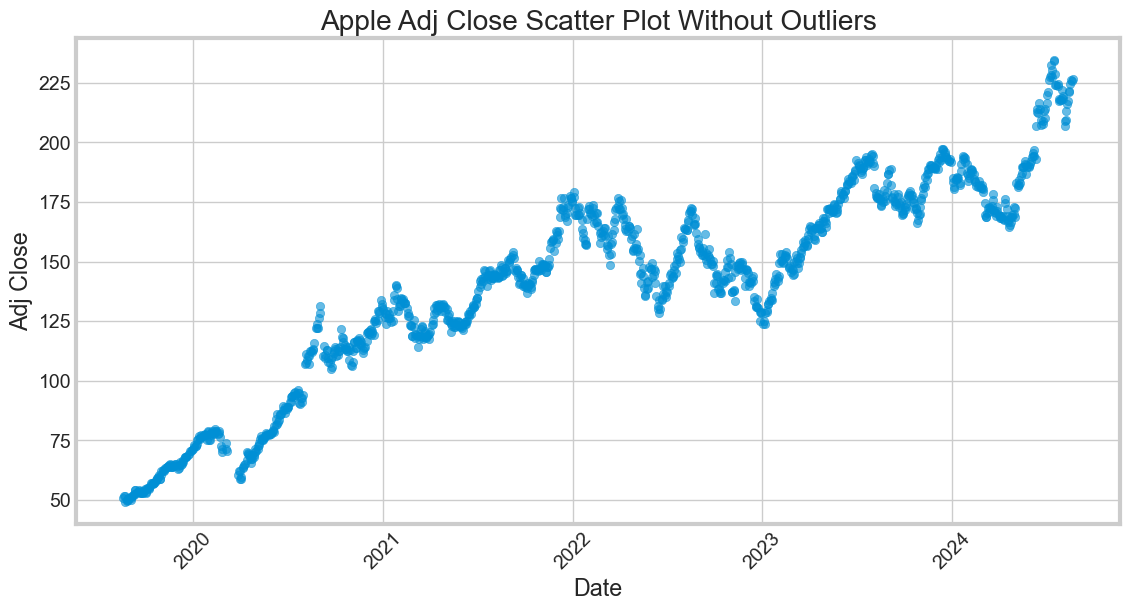

In [5]:
data = company_data['AAPL']
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))

In [ ]:
# Display the first few rows of the dataset to understand its structure
print("First 5 rows of the dataset:")
data_cleaned.head()

In [ ]:
# Display the last few rows of the dataset to understand its structure
print("Last 5 rows of the dataset:")
data_cleaned.tail()

In [ ]:
# Visualize the distribution of numerical features
numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_cleaned[numerical_features].hist(bins=30, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()
#The graphs for Open/High/Low/Close/Adj Close show us a similar pattern:
#The stocks were usually sold at around 150, 
#Volume wise we see its mostly at around 60 

In [ ]:
# A higher (darker) value represents higher correlation between the variables
# A lower (lighter) value represents lower correlation between the variables

plt.figure(figsize=(6,5))
#data_disp = df.drop('company_name', axis=1)
plt.title("Correlation between features")
sns.heatmap(data_cleaned.corr(), cmap='Blues', annot=True);

# There's a high correlation between 5 of the features (Open, High, Low, Close, Adj Close)
# There's a negative correlation between those features and the volume

In [ ]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Close'].plot()
    plt.ylabel('Close')
    plt.xlabel('')
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

In [ ]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel('')
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()
#looks like volume increases monthly (or periodically)

In [ ]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

company_data['GOOG'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

company_data['MSFT'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

company_data['AMZN'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()
#best value to measure is 10-20 days: captures trends w/out noise

In [ ]:
# What was the daily return of the stock on average?
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL']['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

company_data['GOOG']['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

company_data['MSFT']['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

company_data['AMZN']['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

#Harder to interpret, but it easily highlights when the daily returns were really high/low


In [ ]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()
#Allows us to see how risky a stock is
#How likely is the stock to lose/gain value and by how much
#Google looks to have gained the most at once
#However, Apple seems to be the best probabilities 

In [ ]:
#4. What was the correlation between different stocks closing prices?
# Grab all the closing prices for the tech stock list into one DataFrame
close_prices = pd.DataFrame({tech_list[i]: company['Close'] for i, company in enumerate(company_list)})

# Make a new tech returns DataFrame
tech_rets = close_prices.pct_change()
tech_rets.head()

In [ ]:
# Comparing Google to itself should show a perfectly linear relationship
plt.figure(figsize=(6, 5))

sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

plt.title("Linear relationship between Google")
plt.tight_layout()
plt.show()

In [ ]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
plt.figure(figsize=(10, 10))

sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

plt.title("Relationship between Google and Microsoft", fontsize=20,y=1.25)
plt.show()

In [ ]:
# We can simply call pair plot on our DataFrame for an automatic visual analysis 
# of all the comparisons
plt.figure(figsize=(36, 36))

sns.pairplot(tech_rets, kind='reg')

plt.suptitle("Daily Return Prices", fontsize=20,y=1.02) 
plt.tight_layout()
plt.show()
#Most correlation (daily return) between google and amazon

In [ ]:
plt.figure(figsize=(36, 30))

# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, including the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

plt.title("Daily returns",fontsize=20,x=-1.50,y=4.5)
#plt.tight_layout()
plt.show()

#If a density curve is left skewed, then the mean is less than the median.
#If a density curve is right skewed, then the mean is greater than the median.
#Microsoft and Google have the best correlation (daily return) once again.

In [ ]:
plt.figure(figsize=(36, 30))

# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(close_prices)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

plt.title("Closing prices",fontsize=20,x=-1.50,y=4.5)
plt.show()

#If a density curve is left skewed, then the mean is less than the median.
#If a density curve is right skewed, then the mean is greater than the median.
#It's clear that Microsoft and Amazon are the best correlated for closing prices

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer', color='purple')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(close_prices.corr(), annot=True, cmap='summer', color='purple')
plt.title('Correlation of stock closing price')
#There's a high correlation between AAPL and MSFT second to GOOG and MSFT

In [ ]:
# Calculate percentage returns
tech_rets = close_prices.pct_change().dropna()

# Calculate standard deviation of adjusted close prices
std_dev_closing = close_prices.std()

# Calculate standard deviation of returns
std_dev_rets = tech_rets.std()

# Display the standard deviations
print("Standard Deviation of Closing Prices (last 5 years):")
print(std_dev_closing)
print("\nStandard Deviation of Daily Returns (last 5 years):")
print(std_dev_rets)

In [6]:
#Set Target Variableth
#Can filter close either or way
#output_var = pd.DataFrame(data_cleaned, columns=['Close']) 
Target = data_cleaned.filter(['Close'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']
Target.tail

<bound method NDFrame.tail of                  Close
Date                  
2019-08-20   52.590000
2019-08-21   53.160000
2019-08-22   53.115002
2019-08-23   50.660000
2019-08-26   51.622501
...                ...
2024-08-14  221.720001
2024-08-15  224.720001
2024-08-16  226.050003
2024-08-19  225.889999
2024-08-20  226.509995

[1231 rows x 1 columns]>

In [7]:
#Scaling
scaler = MinMaxScaler(feature_range= (0,1))
feature_transform = scaler.fit_transform(data_cleaned[features])
feature_transform = pd.DataFrame(columns = features, data = feature_transform, index = data_cleaned.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2019-08-20,0.009140,0.010266,0.012743,0.375445
2019-08-21,0.011984,0.010670,0.014494,0.279230
2019-08-22,0.012254,0.011733,0.013331,0.292151
2019-08-23,0.007185,0.008517,0.000000,0.734008
2019-08-26,0.002373,0.001978,0.005551,0.360323


In [8]:
#Splitting to Training, Testing and Validation set
timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(feature_transform):
    # Define the training and testing sets
    X_train = feature_transform[:len(train_index)]
    X_test = feature_transform[len(train_index): (len(train_index) + len(test_index))]
    y_train = Target[:len(train_index)].values.ravel()
    y_test =Target[len(train_index): (len(train_index) + len(test_index))].values.ravel()
    
     # Further split the training set into training and validation sets
    
    split_ratio = 0.8 # Example: 80% of the training data for training, 20% for validation
    split_point = int(len(X_train) * split_ratio)
    
    X_train_temp = X_train[:split_point]
    X_val = X_train[split_point:]
    
    y_train_final = y_train[:split_point]
    y_val = y_train[split_point:]    
    # The Data is now split into training, validation and testing sets  
    print("Shape of feature_transform:", feature_transform.shape)
    
print("Shape after split - X_train:", X_train.shape)
print("Shape after split - X_val and X_train_temp:", X_val.shape, X_train_temp.shape)
print("Shape after split - X_test:", X_test.shape)


Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape of feature_transform: (1231, 4)
Shape after split - X_train: (1120, 4)
Shape after split - X_val and X_train_temp: (224, 4) (896, 4)
Shape after split - X_test: (111, 4)


In [9]:
# Process the data for LSTM, turn them into np arrays
X_train_temp = np.array(X_train_temp)
X_val = np.array(X_val)
X_test = np.array(X_test)


# Reshape them into 3D format
X_train_final = X_train_temp.reshape((X_train_temp.shape[0], 1, X_train_temp.shape[1]))
X_val_final = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_final = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print('Final X training set: ', X_train_final.shape)
print("Final X validation set shape: ", X_val_final.shape)
print("Final X test set shape: ", X_test_final.shape)



Final X training set:  (896, 1, 4)
Final X validation set shape:  (224, 1, 4)
Final X test set shape:  (111, 1, 4)


In [42]:
model = Sequential()
model.add(Input(shape=(1,X_train_final.shape[2])))
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

model.add(LSTM(64, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(25))

model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='MeanAbsoluteError',metrics=['MeanAbsoluteError'])
# Ensure model is built
model.build((None, 1, X_train_final.shape[2]))

early_stopping = EarlyStopping(monitor='val_MeanAbsoluteError', patience=10, restore_best_weights=True,mode='min')

plot_model(model, show_shapes=True, show_layer_names=True)

history =model.fit(X_train_final, y_train_final, batch_size = 1, epochs =30, validation_data=(X_val_final, y_val),callbacks=[early_stopping],verbose=1)

Epoch 1/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - MeanAbsoluteError: 60.4750 - loss: 60.4750 - val_MeanAbsoluteError: 7.3713 - val_loss: 7.3713
Epoch 2/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - MeanAbsoluteError: 21.5218 - loss: 21.5218 - val_MeanAbsoluteError: 9.8427 - val_loss: 9.8427
Epoch 3/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - MeanAbsoluteError: 18.6301 - loss: 18.6301 - val_MeanAbsoluteError: 13.9872 - val_loss: 13.9872
Epoch 4/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - MeanAbsoluteError: 15.8932 - loss: 15.8932 - val_MeanAbsoluteError: 6.5315 - val_loss: 6.5315
Epoch 5/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - MeanAbsoluteError: 14.4541 - loss: 14.4541 - val_MeanAbsoluteError: 12.9549 - val_loss: 12.9549
Epoch 6/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - MeanAbsoluteError: 12.9663 - loss: 12.9663 - val_MeanAbsoluteError: 9.3185 - val_loss: 9.3185
Epoch 7/30
896/896 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - MeanAbsoluteError: 13.0456 - loss: 13.0456 - val_Mean

In [44]:
y_pred = model.predict(X_test_final)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 526ms/step


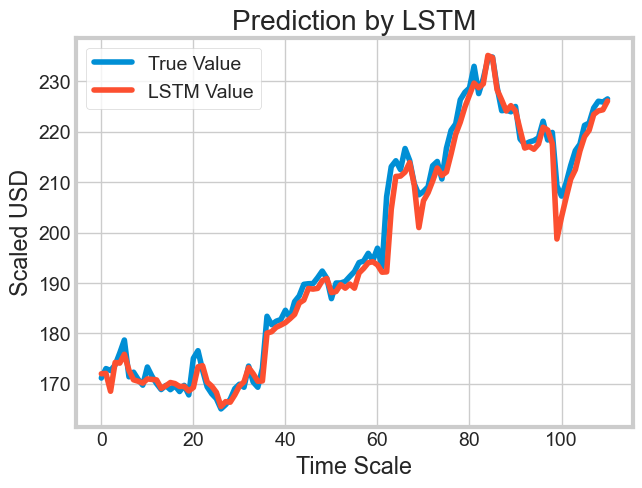

In [45]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


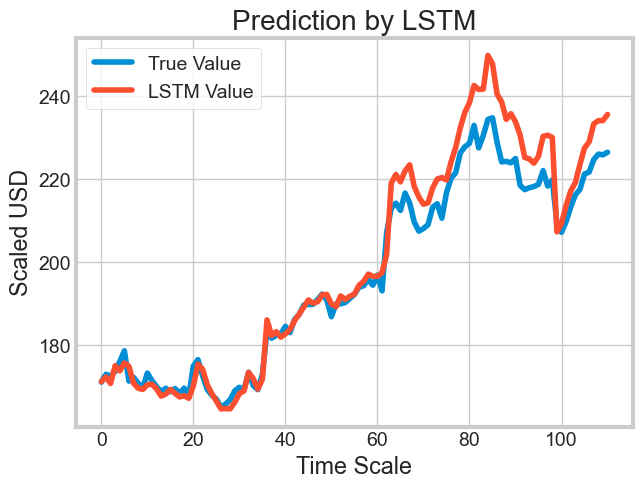

In [39]:
y_pred = model.predict(X_test_final)
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

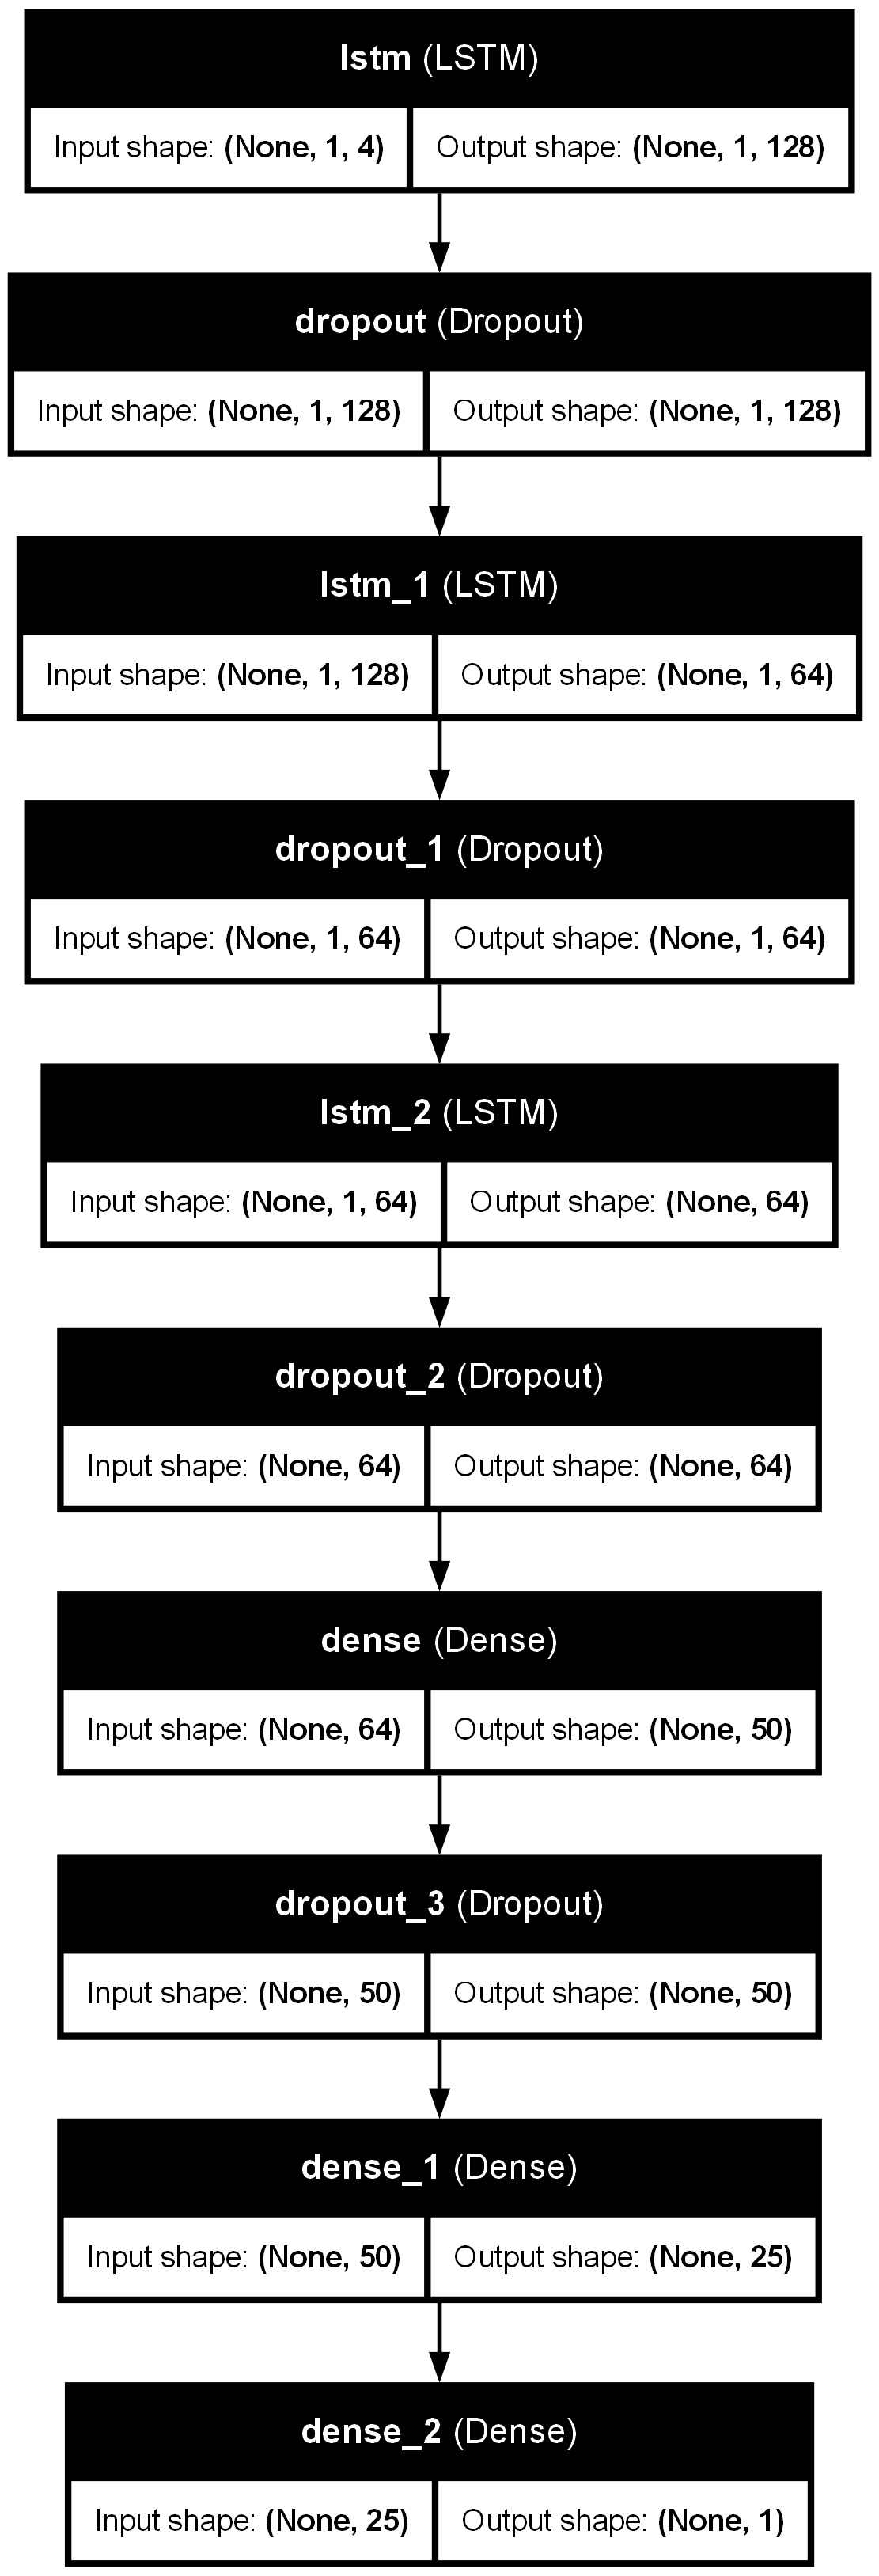

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)